In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moazeldsokyx/plantvillage")

print("Path to dataset files:", path)

100%|██████████| 329M/329M [00:03<00:00, 96.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/moazeldsokyx/plantvillage/versions/1


In [2]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 131.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.19.0
    Uninstalling tensorflow-2.19.0:
      Successfully uninstalled tensorflow-2.19.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is in

In [3]:
import os  # Operating system-specific functionality.
import matplotlib.pyplot as plt  # Plotting library for creating visualizations.
import numpy as np  # Numerical computing library for handling arrays and mathematical operations.
import matplotlib.image as mpimg  # Library for reading and displaying images.
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Part of TensorFlow for real-time data augmentation during model training.
import tensorflow as tf  # Deep learning framework.
from tensorflow.keras.models import Sequential  # Keras sequential model for building neural networks.
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Keras layers for building neural networks.
from tensorflow.keras.callbacks import ModelCheckpoint  # Callback in Keras for saving the model during training.
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Setting random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

print("TensorFlow successfully updated to version:", tf.__version__)

TensorFlow successfully updated to version: 2.20.0


In [4]:
dataset_path = r"/root/.cache/kagglehub/datasets/moazeldsokyx/plantvillage/versions/1/dataset"

# Listing the contents (files and directories) of the  dataset
os.listdir(dataset_path)

['test', 'train', 'validation']

In [5]:
# Creating path for the training subset of the dataset
train_path = os.path.join(dataset_path, 'train')

# Creating path for the validation subset of the dataset
validation_path = os.path.join(dataset_path, 'validation')

# Creating path for the test subset of the dataset
test_path = os.path.join(dataset_path, 'test')

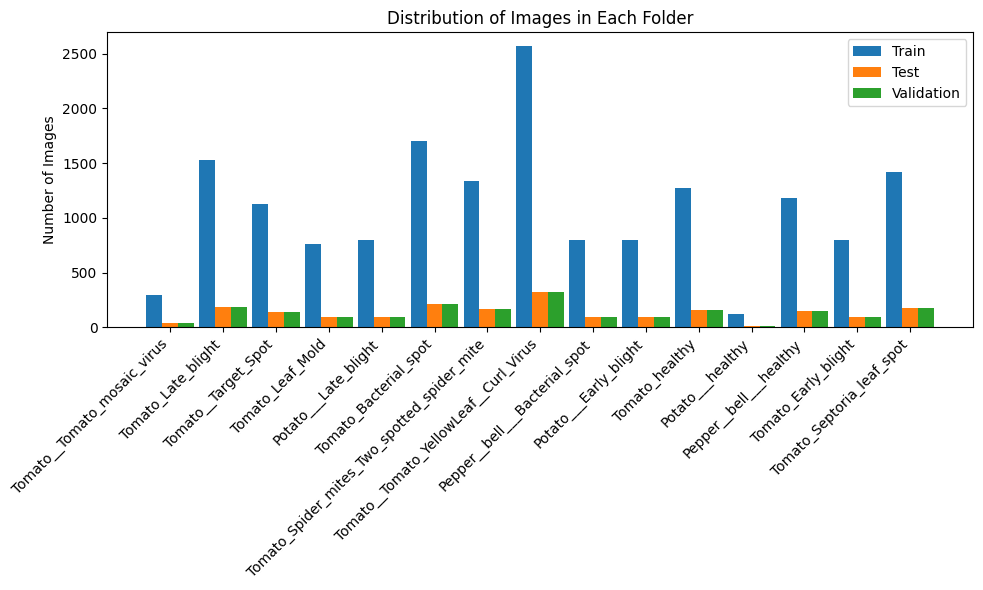

In [6]:
# Defining the folders representing different subsets of the dataset
folders = ['train', 'test', 'validation']

# Dictionary to store the lengths of subfolders in each dataset subset
subfolder_lengths = {folder: {} for folder in folders}

# Iterating through each folder (train, test, validation)
for folder in folders:
    # Getting the list of subfolders within the current dataset subset
    subfolders = os.listdir(os.path.join(dataset_path, folder))

    # Iterating through each subfolder
    for subfolder in subfolders:
        # Calculating the number of files (images) in the current subfolder
        subfolder_length = len(os.listdir(os.path.join(dataset_path, folder, subfolder)))

        # Storing the subfolder length in the dictionary
        subfolder_lengths[folder][subfolder] = subfolder_length

# Extracting subfolder names and their respective lengths for plotting
subfolder_names = list(subfolder_lengths['train'].keys())
train_lengths = list(subfolder_lengths['train'].values())
test_lengths = list(subfolder_lengths['test'].values())
val_lengths = list(subfolder_lengths['validation'].values())
# Setting up parameters for the bar plot
x = np.arange(len(subfolder_names))
width = 0.3

# Creating a bar plot
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, train_lengths, width, label='Train')
rects2 = ax.bar(x, test_lengths, width, label='Test')
rects3 = ax.bar(x + width, val_lengths, width, label='Validation')

# Adding labels and legend to the plot
ax.set_ylabel('Number of Images')
ax.set_title('Distribution of Images in Each Folder')
ax.set_xticks(x)
ax.set_xticklabels(subfolder_names, rotation=45, ha='right')
ax.legend()

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()


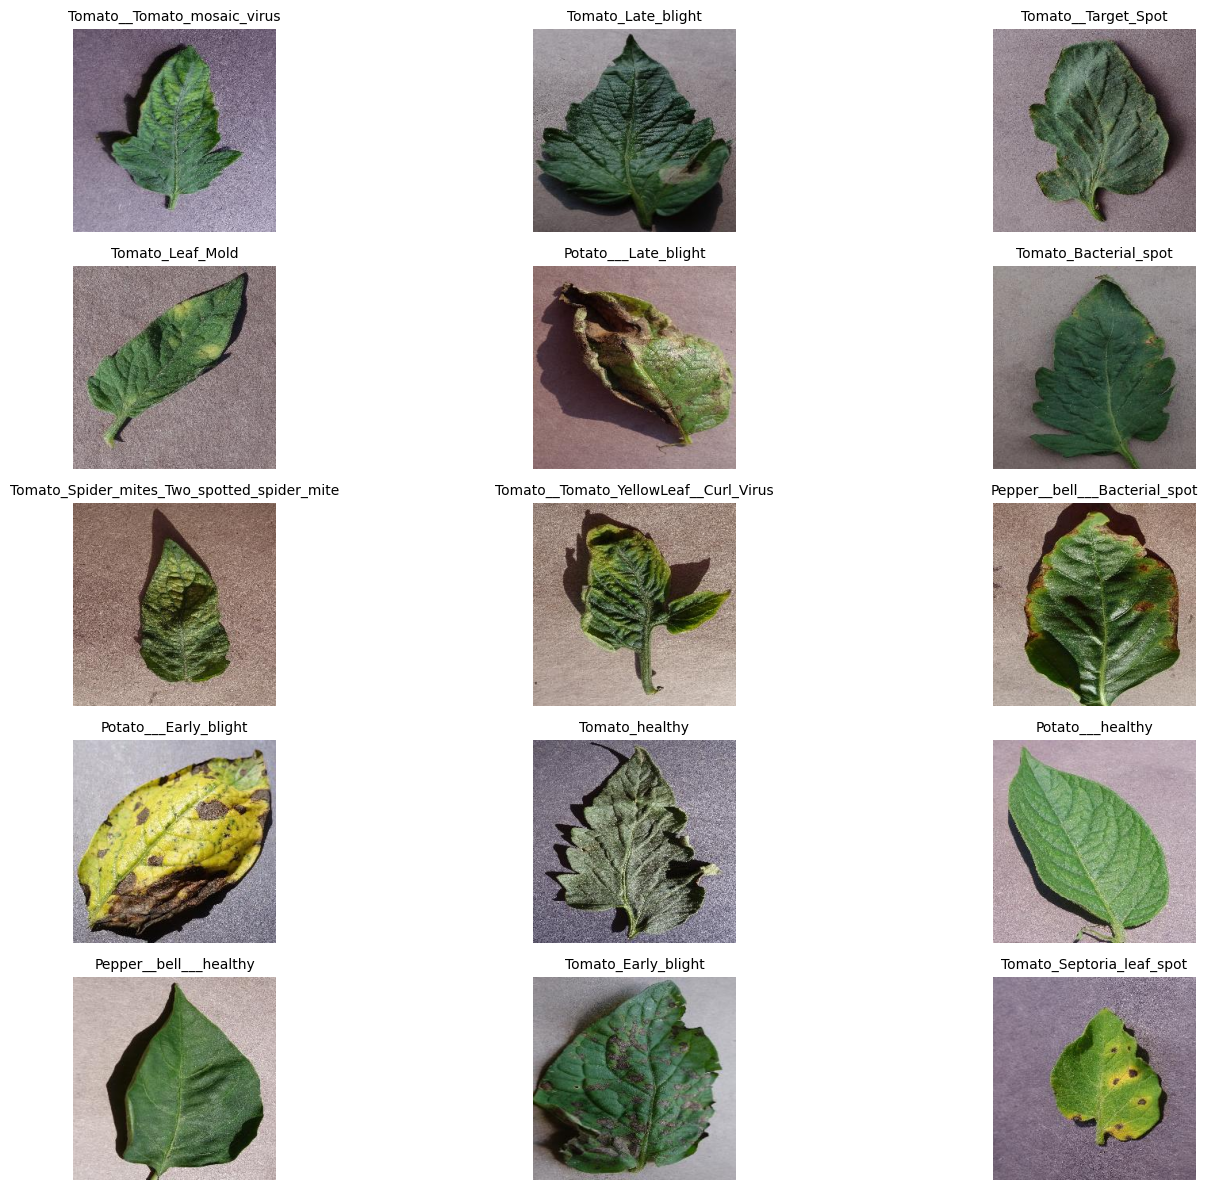

In [7]:
# Create a grid to display the images
num_cols = 3  # Number of columns in the grid
num_rows = 5  # Number of rows in the grid

# Create a matplotlib figure and axis
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
axes = axes.ravel()  # Flatten the axes array for easier indexing

# Loop through subfolders and display an image from each
for i, subfolder in enumerate(subfolders):
    img = [image for image in os.listdir(os.path.join(train_path,subfolder))][0]

    img_path = os.path.join(train_path, subfolder, img)  # Get the first image in the subfolder
    img = mpimg.imread(img_path)  # Load the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis labels
    axes[i].set_title(subfolder, color='black', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [8]:
# Define batch size and image shape for data augmentation
batch_size = 32
image_shape = (256, 256)

# Create an ImageDataGenerator for training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1/255,  # Rescale pixel values to the range [0, 1]
    shear_range=0.2,  # Apply shear transformation with a shear intensity of 0.2
    horizontal_flip=True,  # Randomly flip images horizontally
    vertical_flip=True,  # Randomly flip images vertically
    brightness_range=[0.5, 1.5],  # Adjust brightness between 50% and 150%
    rotation_range=40,  # Rotate images by up to 40 degrees
    zoom_range=0.2  # Randomly zoom into images by 20%
)

# Create a flow generator from the training directory using the defined data augmentation settings
train_generator = train_datagen.flow_from_directory(
    train_path,  # Path to the training dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical"  # Use categorical mode for multi-class classification
)

Found 16504 images belonging to 15 classes.


In [9]:
# Create an ImageDataGenerator for validation data without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1/255  # Rescale pixel values to the range [0, 1]
)

# Create a flow generator from the validation directory
validation_generator = validation_datagen.flow_from_directory(
    validation_path,  # Path to the validation dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical"  # Use categorical mode for multi-class classification
)

Found 2070 images belonging to 15 classes.


In [10]:
# Create an ImageDataGenerator for test data without augmentation
test_datagen = ImageDataGenerator(
    rescale=1/255  # Rescale pixel values to the range [0, 1]
)

# Create a flow generator from the test directory
test_generator = test_datagen.flow_from_directory(
    test_path,  # Path to the test dataset
    target_size=image_shape,  # Resize images to the specified shape
    batch_size=batch_size,  # Set the batch size
    class_mode="categorical",  # Use categorical mode for multi-class classification
    shuffle=False  # Do not shuffle the data to preserve order for evaluation
)

Found 2064 images belonging to 15 classes.


In [11]:
# Create a Sequential model
model = Sequential()

# Add a 2D convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and input shape of (256, 256, 3)
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))

# Add a max pooling layer with a 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Add another 2D convolutional layer with 64 filters and a 3x3 kernel, followed by a ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max pooling layer with a 2x2 pool size
model.add(MaxPooling2D(pool_size=(2, 2)))

# Repeat the pattern with two more convolutional layers and max pooling layers
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output to a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))
# Add a dropout layer with a dropout rate of 0.2 to prevent overfitting
model.add(Dropout(0.2))

# Add another dense layer with 128 units and ReLU activation
model.add(Dense(128, activation='relu'))

# Add the output layer with 15 units (for 15 classes) and softmax activation for multiclass classification
model.add(Dense(15, activation='softmax'))

# Compile the model using the Adam optimizer, categorical crossentropy loss, and accuracy as the metric
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy', metrics=['accuracy'])

# Define a ModelCheckpoint callback to save the best weights during training
checkpoint_callback = ModelCheckpoint("best_epoch_weights.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Display a summary of the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,583,887 (25.12 MB)

 Trainable params: 6,583,887 (25.12 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Calculate the number of steps per epoch for training and validation
steps_per_epoch = train_generator.n // batch_size
validation_steps = validation_generator.n // batch_size

# Set the number of training epochs
epochs = 15

# Train the model using the fit method with training and validation generators
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback for saving the best weights
)

# Find the epoch with the best accuracy on the validation set
best_epoch = np.argmax(history.history['val_accuracy']) + 1

# Print the best epoch information
print(f"Best epoch is ==> epoch {best_epoch}")

Epoch 1/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.3341 - loss: 2.0419
Epoch 1: val_accuracy improved from -inf to 0.67871, saving model to best_epoch_weights.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 344s 645ms/step - accuracy: 0.3344 - loss: 2.0411 - val_accuracy: 0.6787 - val_loss: 1.0139
Epoch 2/15
  1/515 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.6875 - loss: 0.7857
Epoch 2: val_accuracy did not improve from 0.67871
515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.6875 - loss: 0.7857 - val_accuracy: 0.6621 - val_loss: 1.0547
Epoch 3/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 598ms/step - accuracy: 0.6886 - loss: 0.9300
Epoch 3: val_accuracy improved from 0.67871 to 0.72705, saving model to best_epoch_weights.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 312s 606ms/step - accuracy: 0.6886 - loss: 0.9298 - val_accuracy: 0.7271 - val_loss: 0.8562
Epoch 4/15
  1/515 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.8125 - loss: 0.5875
Epoch 4: val_accuracy improved from 0.72705 to 0.74512, saving model to best_epoch_weights.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8125 - loss: 0.5875 - val_accuracy: 0.7451 - val_loss: 0.7906
Epoch 5/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.7646 - loss: 0.6840
Epoch 5: val_accuracy did not improve from 0.74512
515/515 ━━━━━━━━━━━━━━━━━━━━ 311s 603ms/step - accuracy: 0.7646 - loss: 0.6839 - val_accuracy: 0.7441 - val_loss: 0.8238
Epoch 6/15
  1/515 ━━━━━━━━━━━━━━━━━━━━ 42s 82ms/step - accuracy: 0.8438 - loss: 0.3500
Epoch 6: val_accuracy did not improve from 0.74512
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8438 - loss: 0.3500 - val_accuracy: 0.7261 - val_loss: 0.8914
Epoch 7/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8169 - loss: 0.5440
Epoch 7: val_accuracy improved from 0.74512 to 0.86426, saving model to best_epoch_weights.h5


515/515 ━━━━━━━━━━━━━━━━━━━━ 308s 597ms/step - accuracy: 0.8169 - loss: 0.5440 - val_accuracy: 0.8643 - val_loss: 0.4470
Epoch 8/15
  1/515 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.7500 - loss: 0.6905
Epoch 8: val_accuracy did not improve from 0.86426
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7500 - loss: 0.6905 - val_accuracy: 0.8594 - val_loss: 0.4594
Epoch 9/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.8333 - loss: 0.4925
Epoch 9: val_accuracy did not improve from 0.86426
515/515 ━━━━━━━━━━━━━━━━━━━━ 308s 599ms/step - accuracy: 0.8333 - loss: 0.4925 - val_accuracy: 0.8599 - val_loss: 0.4311
Epoch 10/15
  1/515 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8750 - loss: 0.3271
Epoch 10: val_accuracy did not improve from 0.86426
515/515 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8750 - loss: 0.3271 - val_accuracy: 0.8589 - val_loss: 0.4324
Epoch 11/15
515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 590ms/step - accuracy: 0.8632 - loss: 0.3922
Epoch 11: val_ac

515/515 ━━━━━━━━━━━━━━━━━━━━ 306s 594ms/step - accuracy: 0.8752 - loss: 0.3583 - val_accuracy: 0.8784 - val_loss: 0.4181
Best epoch is ==> epoch 15


In [13]:
# Set the best_model variable to the original model
best_model = model

# Compile the best_model using the Adam optimizer, categorical crossentropy loss, and accuracy as the metric
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the best weights saved during training
best_model.load_weights(r'best_epoch_weights.h5')

# Save the entire best_model (architecture and weights) to a file named "plant_leaf_diseases_model.h5"
best_model.save("plant_leaf_diseases_model.h5")

# Indicate that training is complete, and the best model has been saved
print("Training done, and the best model is saved.")

Training done, and the best model is saved.
